In [1]:
%matplotlib inline
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:


def load_summary_results(save_root):
    save_root = Path(save_root)
    session_folders = [f for f in save_root.iterdir() if f.is_dir()]
    
    summary_data = []

    for folder in session_folders:
        json_file = folder / "tongue_quality_stats.json"
        if not json_file.exists():
            continue
        
        with open(json_file, "r") as f:
            results = json.load(f)
        
        # Flatten percentiles into columns
        row = {
            "session_id": results["session_id"],
            "coverage_pct": results["coverage_pct"],
        }
        for metric, pct_dict in results["percentiles"].items():
            for pct, val in pct_dict.items():
                row[f"{metric}_{pct}"] = val

        summary_data.append(row)
    
    return pd.DataFrame(summary_data)





In [3]:

def plot_combined_summary(summary_df):
    # Sort by coverage for barplot
    summary_df_sorted = summary_df.sort_values("coverage_pct")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df_sorted["session_id"], summary_df_sorted["coverage_pct"], color="skyblue")
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df["coverage_pct"], summary_df["dropped_frames_n_0.9"], 
                    color="red", s=70, alpha=0.7, edgecolor='k')
    axes[1].set_xlabel("Coverage (%)")
    axes[1].set_ylabel("Dropped Frames (90th %ile)")
    axes[1].set_title("Dropped Frames vs Coverage")
    axes[1].grid(True, alpha=0.3)

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df["coverage_pct"], summary_df["duration_0.5"], 
                    color="green", s=70, alpha=0.7, edgecolor='k')
    axes[2].set_xlabel("Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Coverage")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()



In [4]:
# Example usage
save_root = "/root/capsule/scratch/session_analysis"
summary_df = load_summary_results(save_root)
summary_df_ood = summary_df[summary_df["session_id"] != "behavior_751004_2024-12-23_14-19-57"]

# Example usage
save_root2 = "/root/capsule/scratch/session_analysis_in_distribution"
summary_df_id = load_summary_results(save_root2)


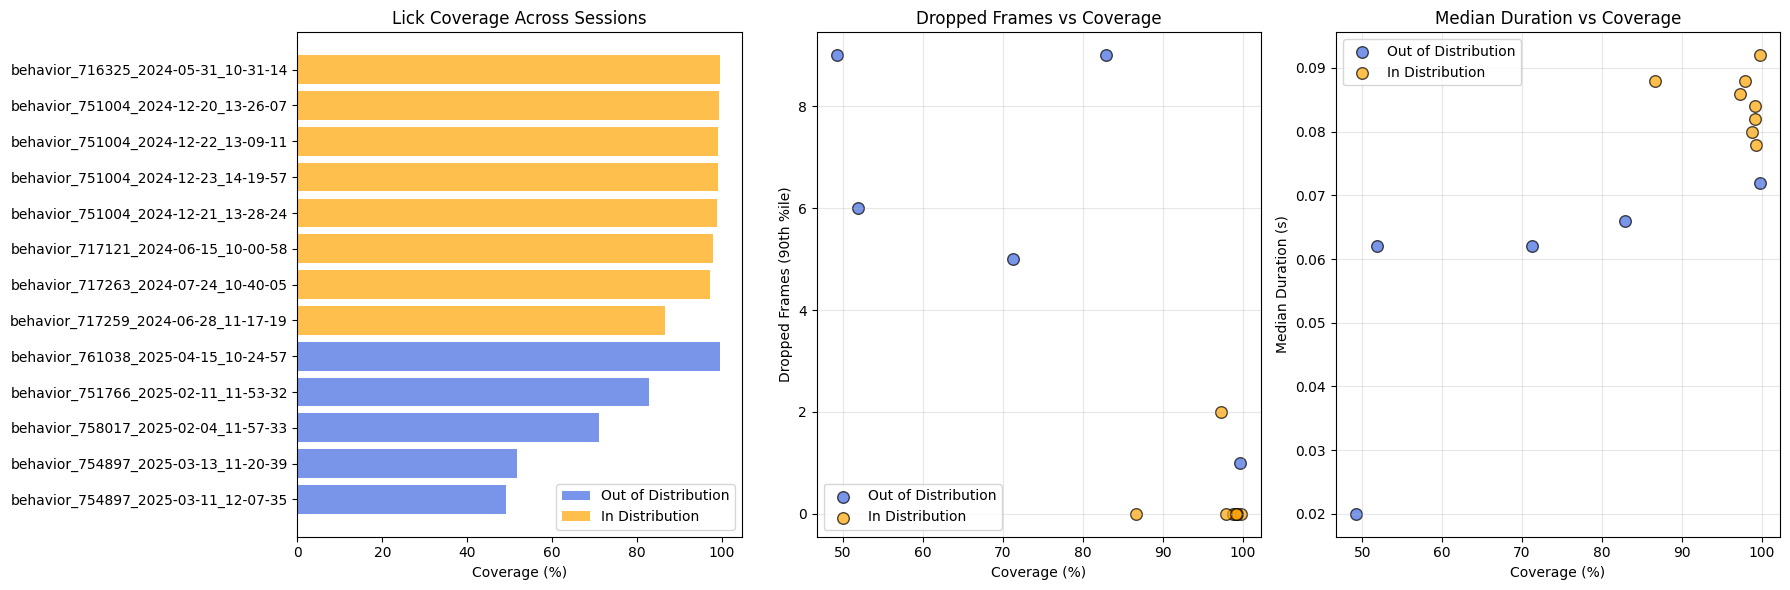

In [5]:
def plot_combined_summary_compare(summary_df1, summary_df2, label1="Out of Distribution", label2="In Distribution"):
    # Sort by coverage for barplot
    summary_df1_sorted = summary_df1.sort_values("coverage_pct")
    summary_df2_sorted = summary_df2.sort_values("coverage_pct")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df1_sorted["session_id"], summary_df1_sorted["coverage_pct"], 
                 color="royalblue", label=label1, alpha=0.7)
    axes[0].barh(summary_df2_sorted["session_id"], summary_df2_sorted["coverage_pct"], 
                 color="orange", label=label2, alpha=0.7)
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")
    axes[0].legend()

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df1["coverage_pct"], summary_df1["dropped_frames_n_0.9"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[1].scatter(summary_df2["coverage_pct"], summary_df2["dropped_frames_n_0.9"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[1].set_xlabel("Coverage (%)")
    axes[1].set_ylabel("Dropped Frames (90th %ile)")
    axes[1].set_title("Dropped Frames vs Coverage")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df1["coverage_pct"], summary_df1["duration_0.5"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[2].scatter(summary_df2["coverage_pct"], summary_df2["duration_0.5"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[2].set_xlabel("Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Coverage")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_combined_summary_compare(summary_df_ood, summary_df_id)

In [6]:
def plot_combined_summary_compare(summary_df1, summary_df2, label1="Out of Distribution", label2="In Distribution"):
    # Combine session_id and coverage_pct from both, drop duplicates, sort by coverage
    combined = pd.concat([
        summary_df1[["session_id", "coverage_pct"]],
        summary_df2[["session_id", "coverage_pct"]]
    ]).drop_duplicates().sort_values("coverage_pct")
    session_order = combined["session_id"].tolist()

    # Reindex both dfs to this order (sessions not present will be dropped)
    summary_df1_sorted = summary_df1.set_index("session_id").reindex(session_order).reset_index()
    summary_df2_sorted = summary_df2.set_index("session_id").reindex(session_order).reset_index()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- 1) Coverage Barplot ---
    axes[0].barh(summary_df1_sorted["session_id"], summary_df1_sorted["coverage_pct"], 
                 color="royalblue", label=label1, alpha=0.7)
    axes[0].barh(summary_df2_sorted["session_id"], summary_df2_sorted["coverage_pct"], 
                 color="orange", label=label2, alpha=0.7)
    axes[0].set_xlabel("Coverage (%)")
    axes[0].set_title("Lick Coverage Across Sessions")
    axes[0].legend()

    # --- 2) Dropped Frames vs Coverage ---
    axes[1].scatter(summary_df1["coverage_pct"], summary_df1["dropped_frames_n_0.9"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[1].scatter(summary_df2["coverage_pct"], summary_df2["dropped_frames_n_0.9"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[1].set_xlabel("Lick Coverage (%)")
    axes[1].set_ylabel("90th %ile Dropped Frames (number)")
    axes[1].set_title("Dropped Frames vs Lick Coverage")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    # --- 3) Duration vs Coverage ---
    axes[2].scatter(summary_df1["coverage_pct"], summary_df1["duration_0.5"], 
                    color="royalblue", s=70, alpha=0.7, edgecolor='k', label=label1)
    axes[2].scatter(summary_df2["coverage_pct"], summary_df2["duration_0.5"], 
                    color="orange", s=70, alpha=0.7, edgecolor='k', label=label2)
    axes[2].set_xlabel("Lick Coverage (%)")
    axes[2].set_ylabel("Median Duration (s)")
    axes[2].set_title("Median Duration vs Lick Coverage")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

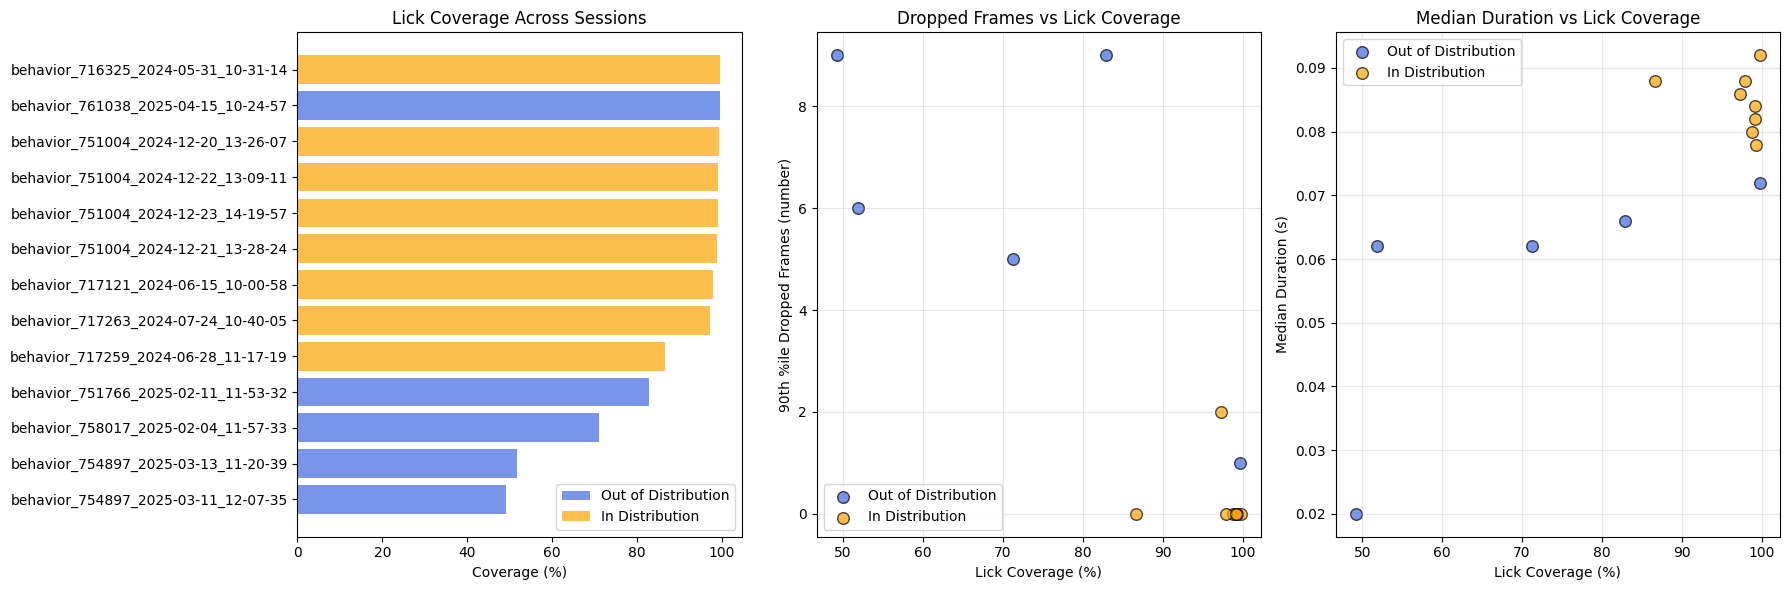

In [7]:
plot_combined_summary_compare(summary_df_ood, summary_df_id)

In [5]:
from IPython.display import display, Image
import subprocess
from pathlib import Path
import io

def extract_frame_from_bad_clip(session_root):
    """
    Extracts the first frame from the first mp4 in the 'bad' subdirectory of a session analysis folder.
    Returns the frame as a bytes object (PNG).
    """
    bad_dir = Path(session_root) / "example_clips" / "bad"
    mp4_files = sorted(bad_dir.glob("*.mp4"))
    if not mp4_files:
        return None
    mp4_path = mp4_files[0]
    # Use ffmpeg to extract the first frame as PNG to stdout
    cmd = [
        "ffmpeg", "-i", str(mp4_path),
        "-ss", "0.66",
        "-vframes", "1",
        "-f", "image2pipe",
        "-vcodec", "png",
        "-"
    ]
    try:
        result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
        return result.stdout
    except subprocess.CalledProcessError:
        return None

def show_session_bad_frame(session_id, save_root):
    """
    Displays the first frame from the first 'bad' mp4 for a given session_id and save_root.
    """
    session_root = Path(save_root) / session_id
    frame_bytes = extract_frame_from_bad_clip(session_root)
    if frame_bytes:
        display(Image(data=frame_bytes))
    else:
        print(f"No frame found for session {session_id}")

# # Example: show a frame for the first session in summary_df
# show_session_bad_frame(summary_df.iloc[0]["session_id"], save_root)

# # Batch: show frames for all sessions in summary_df
# for session_id in summary_df["session_id"]:
#     print(session_id)
#     show_session_bad_frame(session_id, save_root)

In [6]:
from IPython.display import display
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import io
from PIL import Image as PILImage

def extract_frames_from_bad_clip(session_root, n=10, start_time_s=0.0, interval_ms=20):
    """
    Extracts n frames from the first mp4 in the 'bad' subdirectory, spaced by interval_ms, starting at start_time_s.
    Returns a list of PIL Images.
    """
    bad_dir = Path(session_root) / "example_clips" / "bad"
    mp4_files = sorted(bad_dir.glob("*.mp4"))
    if not mp4_files:
        return []
    mp4_path = mp4_files[0]
    frames = []
    for i in range(n):
        timestamp = start_time_s + (i * interval_ms / 1000.0)
        cmd = [
            "ffmpeg", "-ss", f"{timestamp:.3f}", "-i", str(mp4_path),
            "-vframes", "1",
            "-f", "image2pipe",
            "-vcodec", "png",
            "-"
        ]
        try:
            result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
            img = PILImage.open(io.BytesIO(result.stdout))
            frames.append(img)
        except Exception:
            frames.append(None)
    return frames


In [7]:
def show_session_video_reel(session_id, save_root, n=10, start_time_s=0.0, interval_ms=20, max_per_row=5):
    """
    Displays frames from the first 'bad' mp4 for a given session_id and save_root,
    stacking up to max_per_row frames per row.
    """
    session_root = Path(save_root) / session_id
    frames = extract_frames_from_bad_clip(session_root, n=n, start_time_s=start_time_s, interval_ms=interval_ms)
    n_cols = min(max_per_row, n)
    n_rows = (n + max_per_row - 1) // max_per_row
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))
    axes = axes.flatten() if n > 1 else [axes]
    for ax, img in zip(axes, frames):
        ax.axis('off')
        if img is not None:
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "N/A", ha='center', va='center')
    # Hide any unused axes
    for ax in axes[len(frames):]:
        ax.axis('off')
    plt.tight_layout()
#     plt.show()

# # Example usage: show 12 frames, stacked max 5 per row
# show_session_video_reel(summary_df.iloc[0]["session_id"], save_root, n=20, start_time_s=0.5, interval_ms=20, max_per_row=4)

In [ ]:
# Batch: show frames for all sessions in summary_df
for session_id in summary_df["session_id"]:
    print(session_id)
    show_session_video_reel(session_id, save_root, n=20, start_time_s=0.5, interval_ms=20, max_per_row=4)

In [8]:
def show_session_video_reel(
    session_id, save_root, n=10, start_time_s=0.0, interval_ms=20, max_per_row=5, save_path=None, dpi=300
):
    """
    Displays (and optionally saves) frames from the first 'bad' mp4 for a given session_id and save_root,
    stacking up to max_per_row frames per row.
    """
    session_root = Path(save_root) / session_id
    frames = extract_frames_from_bad_clip(session_root, n=n, start_time_s=start_time_s, interval_ms=interval_ms)
    n_cols = min(max_per_row, n)
    n_rows = (n + max_per_row - 1) // max_per_row
    # Try to infer frame size for better aspect ratio (optional)
    frame_width, frame_height = (frames[0].width, frames[0].height) if frames and frames[0] else (3*100, 3*100)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * frame_width / 100, n_rows * frame_height / 100))
    axes = axes.flatten() if n > 1 else [axes]
    for ax, img in zip(axes, frames):
        ax.axis('off')
        if img is not None:
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "N/A", ha='center', va='center')
    for ax in axes[len(frames):]:
        ax.axis('off')
    plt.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, bbox_inches='tight', dpi=dpi)
        plt.close(fig)
    else:
        plt.show()

# for session_id in summary_df["session_id"]:
#     session_root = Path(save_root) / session_id
#     bad_dir = session_root / "example_clips" / "bad"
#     bad_dir.mkdir(parents=True, exist_ok=True)
#     save_path = bad_dir / "video_reel.png"
#     show_session_video_reel(
#         session_id, save_root,
#         n=20, start_time_s=0.5, interval_ms=20,
#         max_per_row=5, save_path=save_path
#     )

In [28]:
# Example usage
save_root_ood = "/root/capsule/scratch/session_analysis_out_of_distribution"
summary_df_ood = load_summary_results(save_root_ood)


for session_id in summary_df_ood["session_id"]:
    session_root = Path(save_root_ood) / session_id
    bad_dir = session_root / "example_clips" / "bad"
    bad_dir.mkdir(parents=True, exist_ok=True)
    save_path = bad_dir / "video_reel.png"
    show_session_video_reel(
        session_id, save_root_ood,
        n=20, start_time_s=0.5, interval_ms=20,
        max_per_row=5, save_path=save_path
    )

In [ ]:

# Example usage
save_root_id = "/root/capsule/scratch/session_analysis_in_distribution"
summary_df_id = load_summary_results(save_root_id)

for session_id in summary_df_id["session_id"]:
    session_root = Path(save_root_id) / session_id
    bad_dir = session_root / "example_clips" / "bad"
    bad_dir.mkdir(parents=True, exist_ok=True)
    save_path = bad_dir / "video_reel.png"
    show_session_video_reel(
        session_id, save_root_id,
        n=20, start_time_s=0.5, interval_ms=20,
        max_per_row=5, save_path=save_path
    )


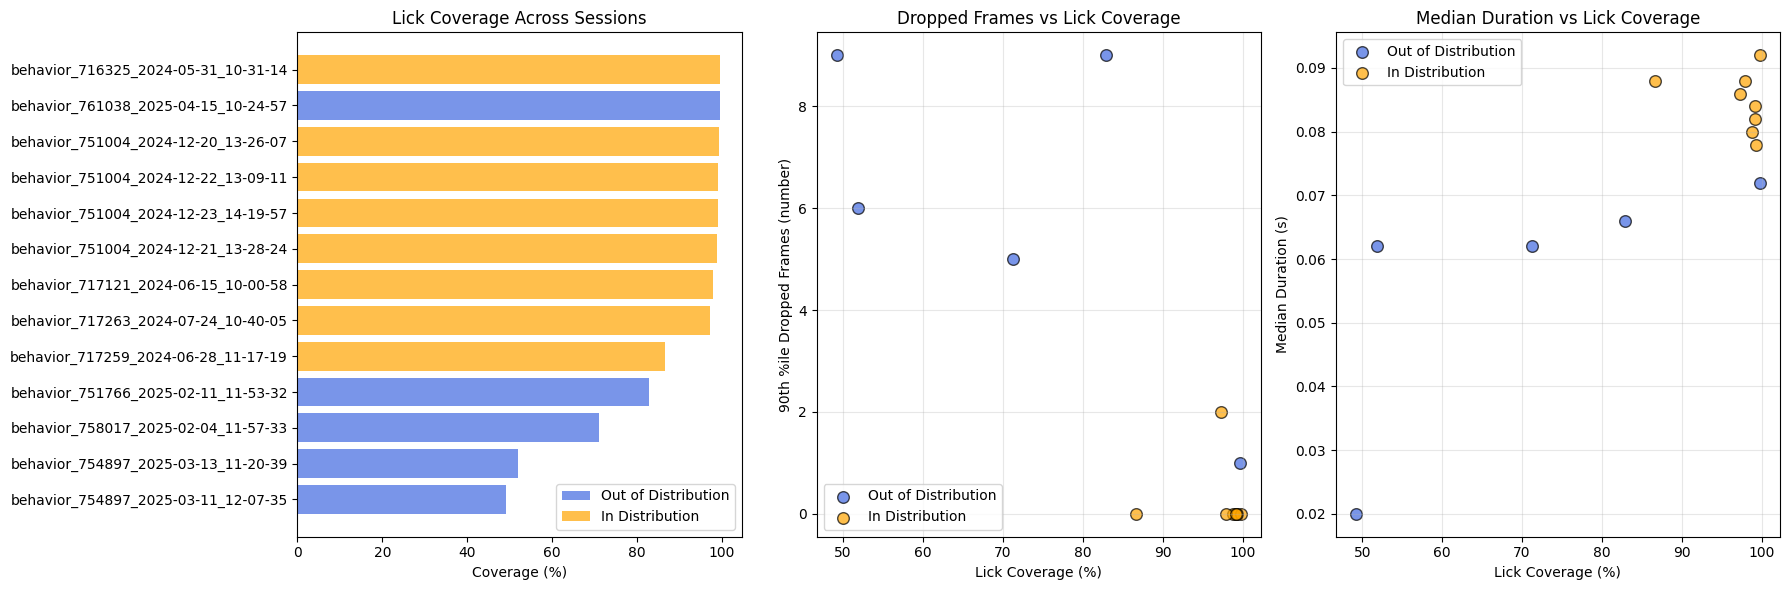

In [7]:
save_root_ood = "/root/capsule/scratch/session_analysis_out_of_distribution"
summary_df_ood = load_summary_results(save_root_ood)

save_root_id = "/root/capsule/scratch/session_analysis_in_distribution"
summary_df_id = load_summary_results(save_root_id)

plot_combined_summary_compare(summary_df_ood, summary_df_id)